## Calculating historical and future projections of global warming in climate model simulations


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/tmp/ipykernel_3704186/411124612.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!


In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

In [5]:
df['experiment_id'].unique()

array(['highresSST-present', 'piControl', 'control-1950', 'hist-1950',
       'historical', 'amip', 'abrupt-4xCO2', 'abrupt-2xCO2',
       'abrupt-0p5xCO2', '1pctCO2', 'ssp585', 'esm-piControl', 'esm-hist',
       'hist-piAer', 'histSST-1950HC', 'ssp245', 'hist-1950HC', 'histSST',
       'piClim-2xVOC', 'piClim-2xNOx', 'piClim-2xdust', 'piClim-2xss',
       'piClim-histall', 'hist-piNTCF', 'histSST-piNTCF',
       'aqua-control-lwoff', 'piClim-lu', 'histSST-piO3', 'piClim-CH4',
       'piClim-NTCF', 'piClim-NOx', 'piClim-O3', 'piClim-HC',
       'faf-heat-NA0pct', 'ssp370SST-lowCH4', 'piClim-VOC',
       'ssp370-lowNTCF', 'piClim-control', 'piClim-aer', 'hist-aer',
       'faf-heat', 'faf-heat-NA50pct', 'ssp370SST-lowNTCF',
       'ssp370SST-ssp126Lu', 'ssp370SST', 'ssp370pdSST', 'histSST-piAer',
       'piClim-ghg', 'piClim-anthro', 'faf-all', 'hist-nat', 'hist-GHG',
       'ssp119', 'piClim-histnat', 'piClim-4xCO2', 'ssp370',
       'piClim-histghg', 'highresSST-future', 'esm-ssp585-

In [6]:
cat = col.search(experiment_id=['ssp585','historical'],  # pick the `historical` forcing experiment
                 table_id='Amon',             # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
                 variable_id='tas',           # choose to look at near-surface air temperature (tas) as our variable
                 member_id = 'r1i1p1f1')      # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)

In [7]:
time_slice = slice('1850','2100') # specific years that bracket our period of interest

In [8]:
from xmip.preprocessing import combined_preprocessing
# convert data catalog into a dictionary of xarray datasets
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})
                                #preprocess=combined_preprocessing,)

ds_dict = {}
for name, ds in tqdm(dset_dict.items()):
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    ds = ds.sel(time=time_slice) # subset the data for the time period of interest
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)
            
    ds_dict[name] = ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


  0%|          | 0/90 [00:00<?, ?it/s]

/home/mdshadman_amin/miniforge3/envs/xMIP/lib/python3.11/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/mdshadman_amin/miniforge3/envs/xMIP/lib/python3.11/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/mdshadman_amin/miniforge3/envs/xMIP/lib/python3.11/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/home/mdshadman

In [9]:
for name, ds in tqdm(ds_dict.items()):
    print(f'In {name} the coordinates are {ds.coords}')

  0%|          | 0/90 [00:00<?, ?it/s]

In CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Amon.gr the coordinates are Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
In CMIP.MPI-M.ICON-ESM-LR.historical.Amon.gn the coordinates are Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
In ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Amon.gr the coordinates are Coordinates:
  * lat      (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
In ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn the coordinates are Coordinates:
  * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
  * lon      (lon) float64 0.0 1.125 2.25 3.

In [ ]:
gmst_dict = {}
for name, ds in tqdm(ds_dict.items()):
    print(f"Dataset: {name}")
    print(f"Coordinates: {ds.coords}")
    # Check if 'lat' and 'lon' exist
    if 'lat' not in ds.coords or 'lon' not in ds.coords:
        print(f"Skipping {name} because 'lat' or 'lon' is missing")
        continue
    # Calculate GMST as before
    cos_lat_2d = np.cos(np.deg2rad(ds['lat'])) * xr.ones_like(ds['lon'])
    gmst = (
        (ds['tas'] * cos_lat_2d).sum(dim=['lat', 'lon']) /
        cos_lat_2d.sum(dim=['lat', 'lon'])
    )
    gmst_dict[name] = gmst.squeeze()
    ds_dict[name] = ds

  0%|          | 0/90 [00:00<?, ?it/s]

Dataset: CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Amon.gr
Coordinates: Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Dataset: CMIP.MPI-M.ICON-ESM-LR.historical.Amon.gn
Coordinates: Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
Skipping CMIP.MPI-M.ICON-ESM-LR.historical.Amon.gn because 'lat' or 'lon' is missing
Dataset: ScenarioMIP.IPSL.IPSL-CM6A-LR.ssp585.Amon.gr
Coordinates: Coordinates:
  * lat      (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2015-01-16T12:00:00 ... 2100-12-16T12:00:00
Dataset: ScenarioMIP.BCC.BCC-CSM2-MR.ssp585.Amon.gn
Coordinates: Coordinates:
  * lat      (lat) float64 -89.14 -88.03

#### Splice together the historical (1850-2014) and SSP simulations (2015+)

In [11]:
ssp_dict = {}
for name, ds in ds_dict.items():
    if 'ssp' not in name: continue
        
    add_hist_ds = None
    
    # Loop through dictionary to find matching historical simulation
    for hist_name, hist_ds in ds_dict.items():
        model_name = name.split(".")[2] # extract model name from name of simulation
        
        # find historical simulation that matches SSP simulation (same model)
        if (model_name in hist_name) and ('historical' in hist_name):
            add_hist_ds = hist_ds
    
    # if we found one, slice it together with the SSP and add it to the dictionary
    if add_hist_ds is not None:
        ds_ssp = xr.concat([add_hist_ds, ds],dim='time')
        ssp_dict[name] = ds_ssp

In [12]:
ssp_dict['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.Amon.gn']['time']

<xarray.DataArray 'time' (time: 3012)>
array([Timestamp('1850-01-16 12:00:00'), Timestamp('1850-02-15 00:00:00'),
       Timestamp('1850-03-16 12:00:00'), ...,
       cftime.DatetimeProlepticGregorian(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16T12:00:00 ... 2100-12-16 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    long_name:      time
    standard_name:  time

#### Visualizing warming patterns from 1890-1910 to 1990-2010

In [13]:
ssp_ds = ssp_dict[list(ssp_dict.keys())[0]]
temperature_change = (
    ssp_ds['tas'].isel(time=slice(2080,2100)).mean(dim='time') - ssp_ds['tas'].isel(time=slice(1980,2000)).mean(dim='time')
).compute()
temperature_change.attrs.update(ssp_ds.attrs)
temperature_change = temperature_change.rename(
    r'temperature change ($^{\circ}$C) from 1980-2000 to 2080-2100'
)

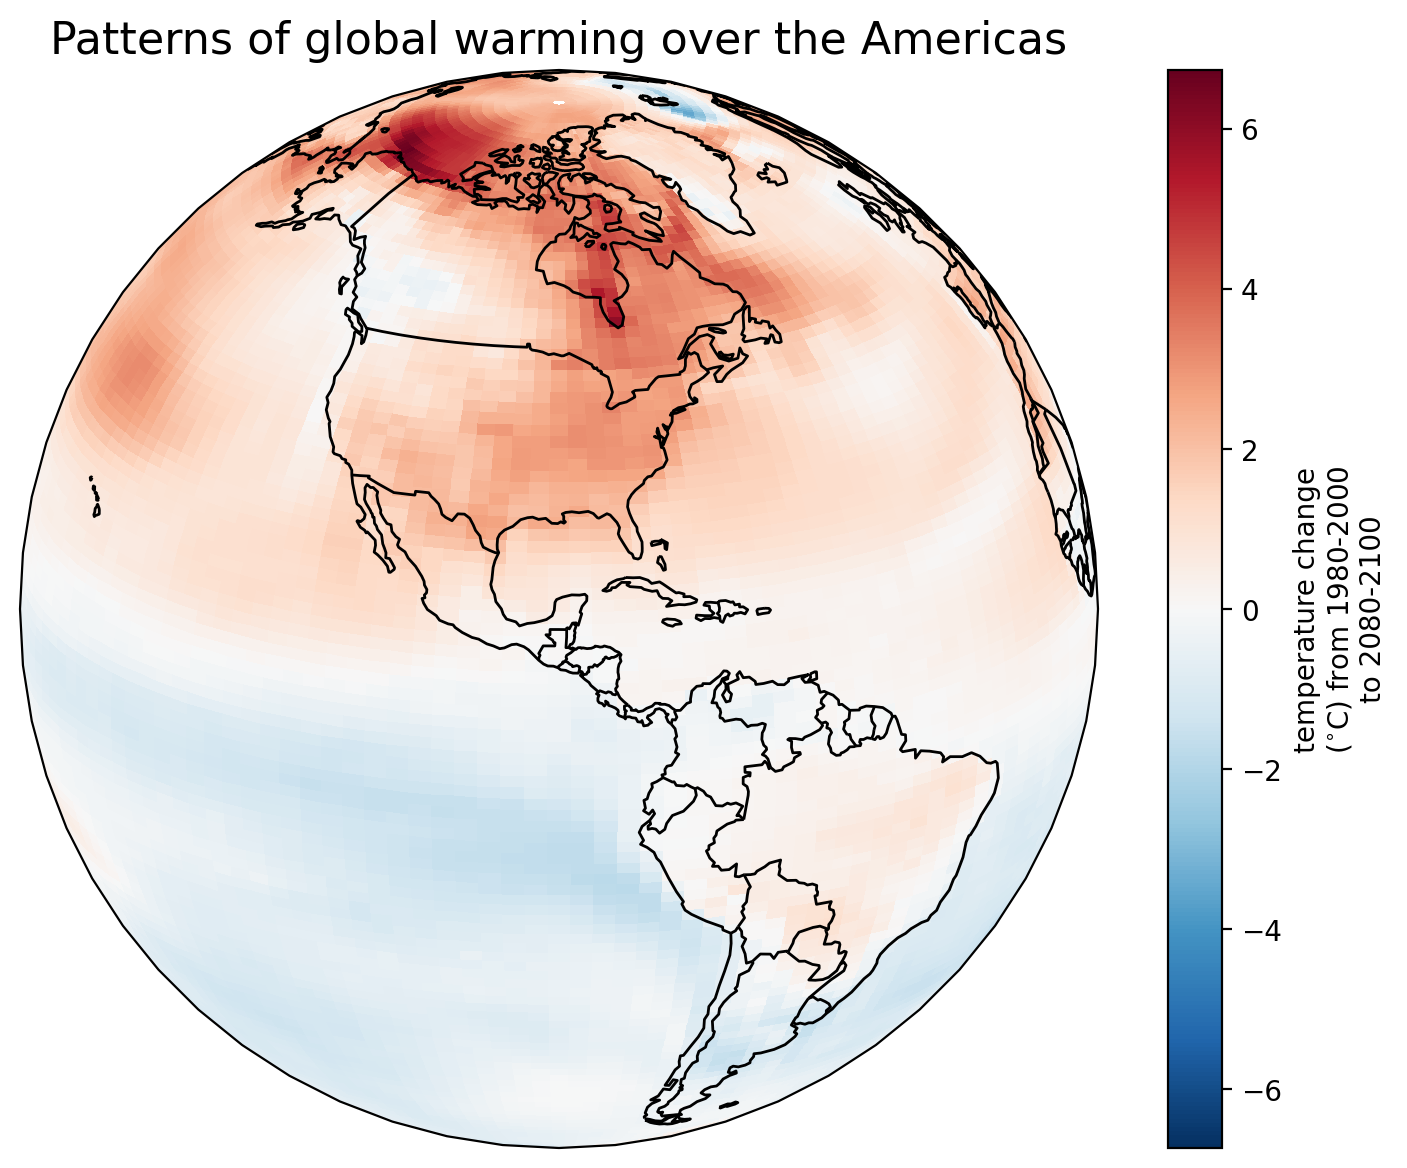

In [14]:
import cartopy.crs as ccrs
ortho = ccrs.Orthographic(-90, 20) # define target coordinate frame
geo = ccrs.PlateCarree() # define origin coordinate frame

plt.figure(figsize=(9,7))
ax = plt.subplot(1, 1, 1, projection=ortho)

q = temperature_change.plot(ax=ax, transform = geo) # plot a colormap in transformed coordinates

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Patterns of global warming over the Americas',fontsize=16, ha='center');
#plt.savefig('../figures/ssp585_warming_patterns.png',dpi=100,bbox_inches='tight')
plt.show()

#### Splice historical and SSP simulations together

In [15]:
gmst_ssp_dict = {} # dictionary that will hold spliced DataArrays
for name, gmst in gmst_dict.items(): # Loop through dictionary
    if 'ssp' not in name: continue # keep only SSP simulations
            
    add_hist_gmst = None
    
    # Loop through dictionary to find matching historical simulation
    for hist_name, hist_gmst in gmst_dict.items():
        model_name = name.split(".")[2] # extract model name from name of simulation
        
        # find historical simulation that matches SSP simulation (same model)
        if (model_name in hist_name) and ('historical' in hist_name):
            add_hist_gmst = hist_gmst
    
    # if we found one, slice it together with the SSP and add it to the dictionary
    if add_hist_gmst is not None:
        gmst_ssp = xr.concat([add_hist_gmst, gmst],dim='time')
        gmst_ssp_dict[name] = gmst_ssp

In [16]:
gmst_ssp_dict['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.Amon.gn']['time'].values

array([Timestamp('1850-01-16 12:00:00'), Timestamp('1850-02-15 00:00:00'),
       Timestamp('1850-03-16 12:00:00'), ...,
       cftime.DatetimeProlepticGregorian(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeProlepticGregorian(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [17]:
for name, gmst in tqdm(gmst_ssp_dict.items()): # loop through each model
    
    # remove the climatological seasonal cycle from the signal, for visual clarity
    gmst['time'] = gmst['time'].astype('datetime64[ns]')
    gmst_climatology = gmst.groupby(gmst['time'].dt.month).mean('time')
    gmst_anomalies = gmst.groupby(gmst['time'].dt.month) - gmst_climatology
    
    # reference the GMST relative to the 1850 to 1900 pre-industrial period
    gmst_anomalies = gmst_anomalies - gmst_anomalies.isel(time=slice(1850,1900)).mean(dim='time')
    
    # calculate annual-averages, to smooth the time-series a bit
    gmst_ann_anomalies = gmst_anomalies.groupby(gmst_anomalies['time'].dt.year).mean('time')
    gmst_ann_anomalies = gmst_ann_anomalies.rename(
        r'global-mean surface temperature ($^{\circ}$C) (relative to 1850-1900)'
    )
    
    gmst_ssp_dict[name] = gmst_ann_anomalies.compute() # eager calculation of global-mean surface temperature

  0%|          | 0/35 [00:00<?, ?it/s]

/home/mdshadman_amin/miniforge3/envs/xMIP/lib/python3.11/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 251 times more chunks
  return self.array[key]
/home/mdshadman_amin/miniforge3/envs/xMIP/lib/python3.11/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 251 times more chunks
  return self.array[key]
/home/mdshadman_amin/miniforge3/envs/xMIP/lib/python3.11/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 251 times more chunks
  return self.array[key]
/home/mdshadman_amin/miniforge3/envs/xMIP/lib/python3.11/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 251 times more chunks
  return self.array[key]
/home/mdshadman_amin/miniforge3/envs/xMIP/lib/python3.11/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing wit

#### Plotting a timeseries of global warming from 1850-2019

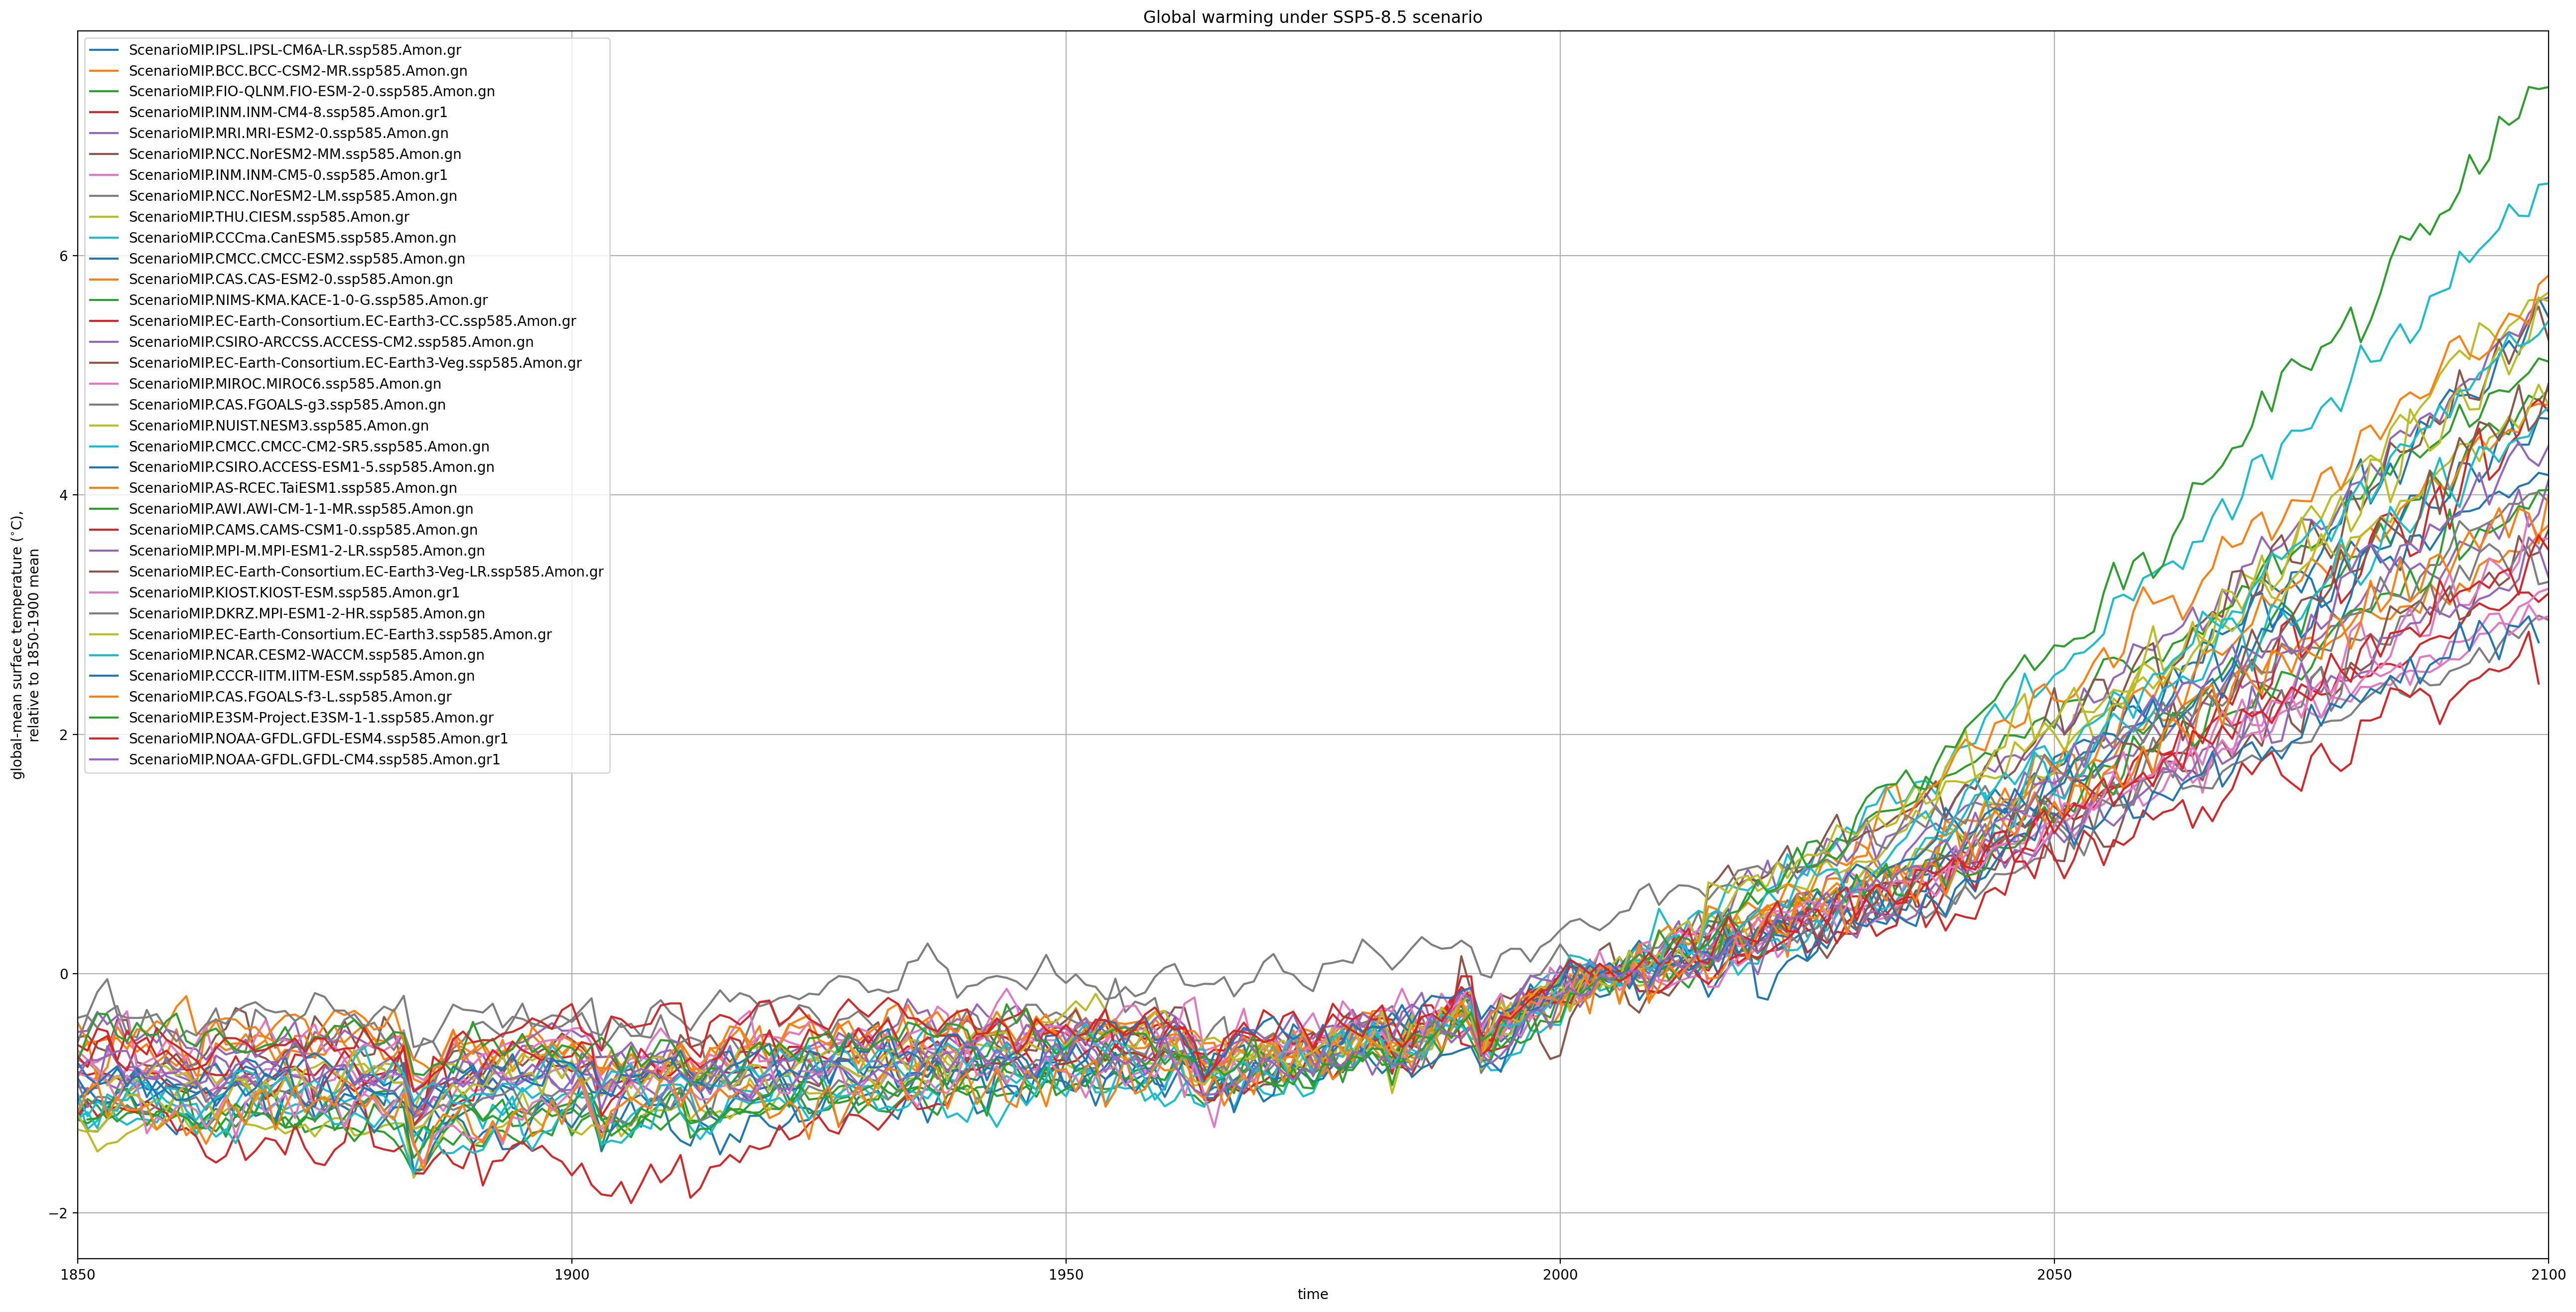

In [20]:
plt.figure(figsize=(32,16))

for name, gmst_ssp in gmst_ssp_dict.items():
    gmst_ssp.plot()
    
plt.xlabel('time')
plt.ylabel(r'global-mean surface temperature ($^{\circ}$C),'
           '\n'
           'relative to 1850-1900 mean')
plt.title('Global warming under SSP5-8.5 scenario')
plt.grid(True)
plt.legend(gmst_ssp_dict.keys(), loc='upper left')
plt.xlim([1850,2100]);
#plt.savefig('../figures/ssp585_global_warming.png',dpi=100,bbox_inches='tight')
plt.show()